In [107]:
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# relevant classification model packages 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [137]:
data = pd.read_csv('/kaggle/input/churn-data/WA_Fn-UseC_-Telco-Customer-Churn.csv.xls')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Basic Info

In [138]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [139]:
## total charges should be numerical, not object
# change TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
# calculate percentage of NaN in TotalCharges
((data['TotalCharges'].isnull().sum()) / len(data['TotalCharges'])) * 100 # 0.156%

0.1561834445548772

In [140]:
# since percentage of NaN in TotalCharges is low, I will drop NaN's instead of imputation
data = data.dropna(subset=['TotalCharges'])

In [141]:
# check if NaN's were dropped
data['TotalCharges'].isnull().sum()

0

## Check for nulls

In [142]:
## function to calculate percentage of missing data % by column given a data frame
def missing_perc(df):
    missing_df = pd.DataFrame()
    missing_df['Col Name'] = list(df.columns)
    missing_df['Missing %'] = [round(i/df.shape[0] * 100,2) for i in df.isnull().sum()]
    missing_df.sort_values(by=['Missing %'], ascending=False,inplace=True)
    missing_df['Missing %'] = missing_df['Missing %'].astype('str') + '%'
    pd.set_option('display.max_rows', None)
    return missing_df

In [143]:
missing_perc(data) # no nulls 

,Col Name,Missing %
0,customerID,0.0%
11,DeviceProtection,0.0%
19,TotalCharges,0.0%
18,MonthlyCharges,0.0%
17,PaymentMethod,0.0%
16,PaperlessBilling,0.0%
15,Contract,0.0%
14,StreamingMovies,0.0%
13,StreamingTV,0.0%
12,TechSupport,0.0%


## Categorical Data Analysis

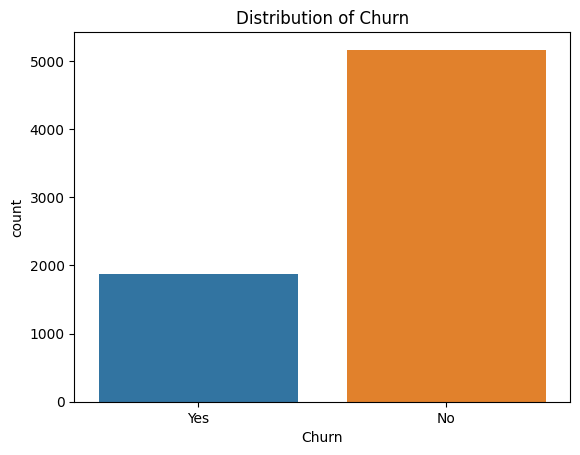

In [46]:
# distribution of churn
sns.countplot(x = 'Churn', data = data, order = ['Yes', 'No'])
plt.title('Distribution of Churn')
plt.show()

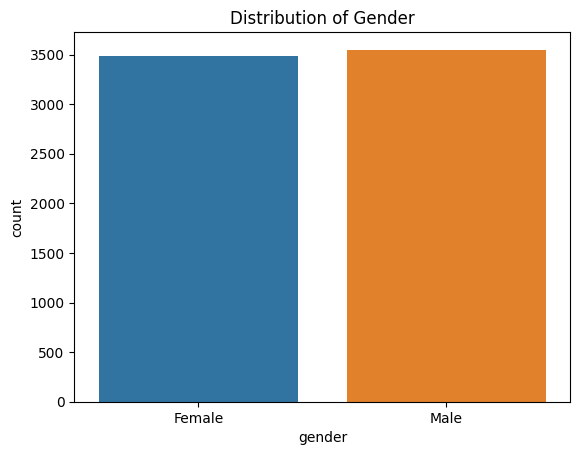

In [47]:
# distribution of gender
sns.countplot(x = 'gender', data=data)
plt.title('Distribution of Gender')
plt.show()

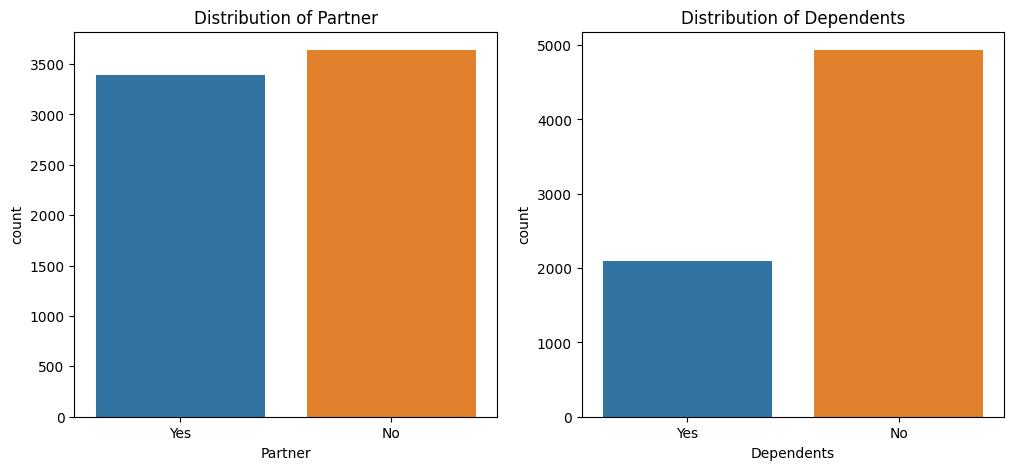

In [48]:
# distribution of partner and dependents
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='Partner', data=data, ax=axs[0], order=['Yes', 'No'])
axs[0].set_title('Distribution of Partner')
sns.countplot(x='Dependents', data=data, ax=axs[1], order=['Yes', 'No'])
axs[1].set_title('Distribution of Dependents')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


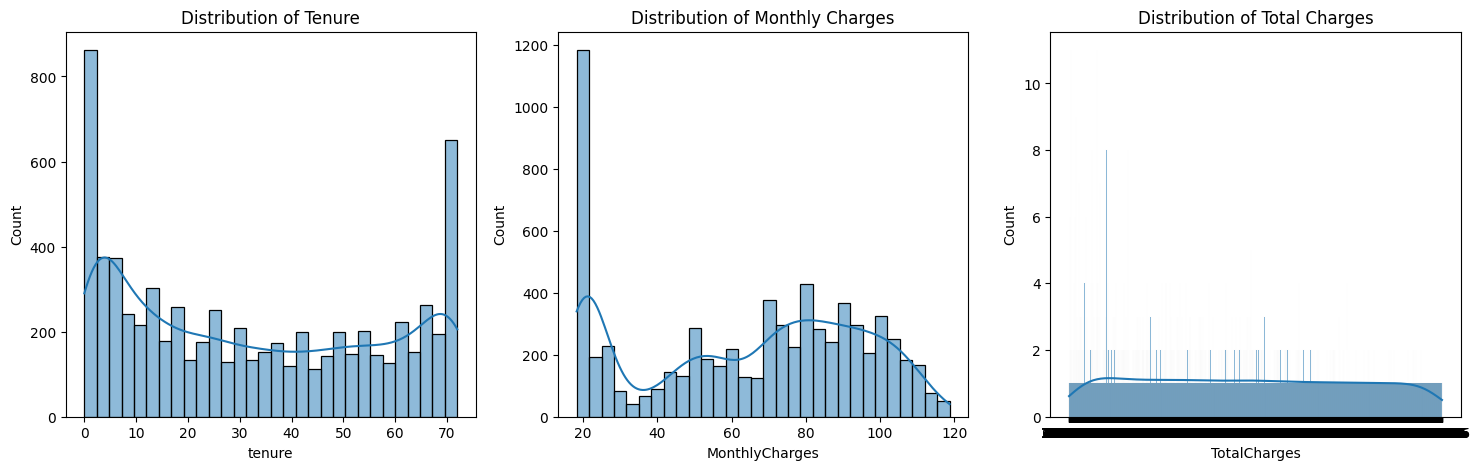

In [44]:
# distribution of tenure, MonthlyCharges, and TotalCharges
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data['tenure'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Tenure')
sns.histplot(data['MonthlyCharges'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Monthly Charges')
sns.histplot(data['TotalCharges'], bins=10, kde=True, ax=axs[2])
axs[2].set_title('Distribution of Total Charges')
plt.show()

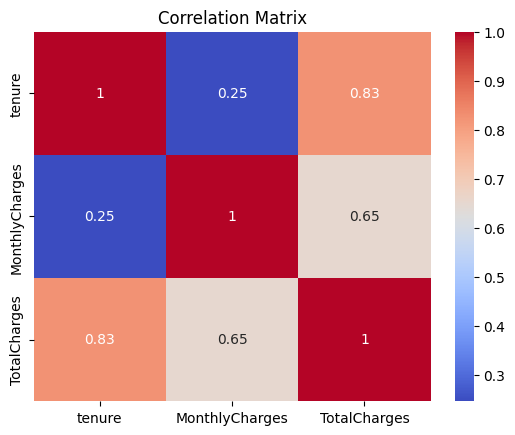

In [49]:
# correlation matrix using tenure, MonthlyCharges, TotalCharges
correlation_matrix = data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

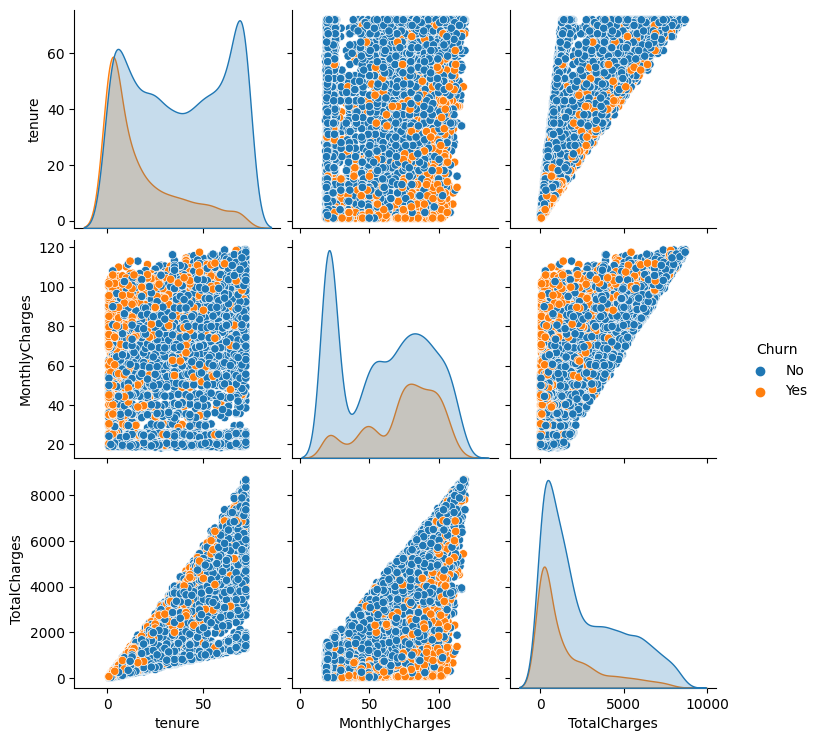

In [50]:
# pair plots
sns.pairplot(data[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')
plt.show()

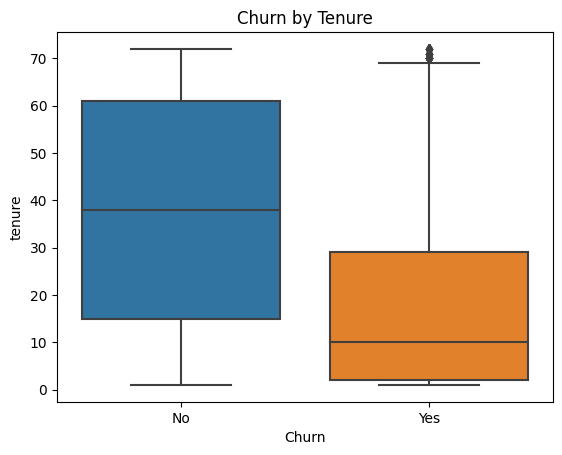

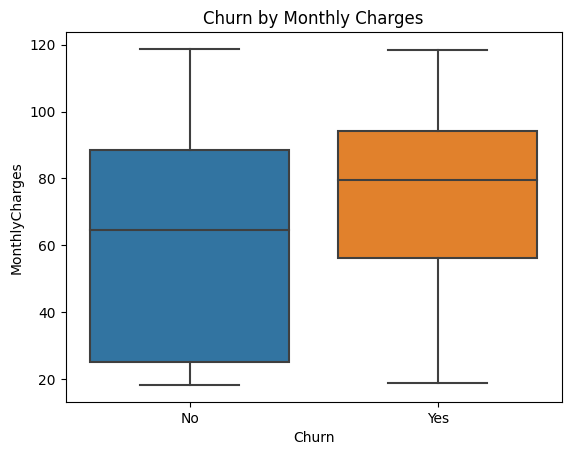

In [51]:
# churn by tenure
sns.boxplot(x='Churn', y='tenure', data=data)
plt.title('Churn by Tenure')
plt.show()

# churn by MonthlyCharges
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('Churn by Monthly Charges')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


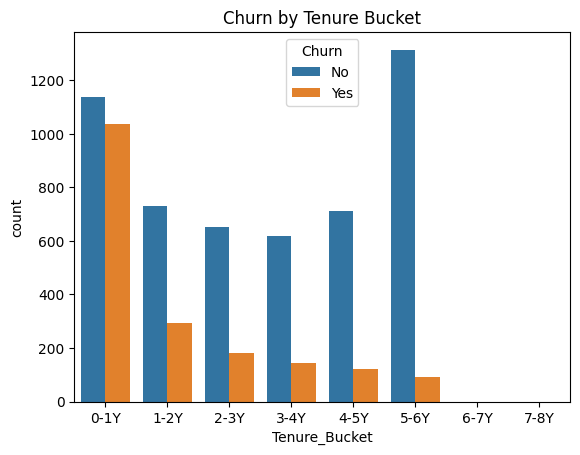

In [52]:
# tenure buckets
data['Tenure_Bucket'] = pd.cut(data['tenure'], bins=[0, 12, 24, 36, 48, 60, 72, 84, 96], labels=['0-1Y', '1-2Y', '2-3Y', '3-4Y', '4-5Y', '5-6Y', '6-7Y', '7-8Y'])
sns.countplot(x='Tenure_Bucket', hue='Churn', data=data)
plt.title('Churn by Tenure Bucket')
plt.show()

# Data Preprocessing

In [144]:
## OneHotEncoder
# categorical columns to encode
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 
                       'Contract', 'PaymentMethod', 'MultipleLines', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                       'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

# initialize OneHotEncoder 
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False)

# fit and transform the encoder on categorical columns
encoded_features = OH_encoder.fit_transform(data[categorical_columns])

# convert the encoded columns into a dataframe
encoded_df = pd.DataFrame(encoded_features, columns=OH_encoder.get_feature_names_out(categorical_columns))

# drop original categorical columns and concat encoded columns
data_encoded = pd.concat([data.drop(columns=categorical_columns), encoded_df], axis=1)

data_encoded.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes
0,7590-VHVEG,0.0,1.0,29.85,29.85,No,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,5575-GNVDE,0.0,34.0,56.95,1889.50,No,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3668-QPYBK,0.0,2.0,53.85,108.15,Yes,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,0.0,45.0,42.30,1840.75,No,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,9237-HQITU,0.0,2.0,70.70,151.65,Yes,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [145]:
data_encoded.isna().sum()

customerID                                 11
SeniorCitizen                              11
tenure                                     11
MonthlyCharges                             11
TotalCharges                               11
Churn                                      11
gender_Female                              11
gender_Male                                11
Partner_No                                 11
Partner_Yes                                11
Dependents_No                              11
Dependents_Yes                             11
PhoneService_No                            11
PhoneService_Yes                           11
InternetService_DSL                        11
InternetService_Fiber optic                11
InternetService_No                         11
Contract_Month-to-month                    11
Contract_One year                          11
Contract_Two year                          11
PaymentMethod_Bank transfer (automatic)    11
PaymentMethod_Credit card (automat

In [146]:
data_encoded = data_encoded.dropna()

# Feature Engineering

In [147]:
# creating an interaction feature between tenure and MonthlyCharges
data_encoded['Tenure_MonthlyCharges'] = data_encoded['tenure'] * data_encoded['MonthlyCharges']

In [148]:
data_encoded.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Tenure_MonthlyCharges
0,7590-VHVEG,0.0,1.0,29.85,29.85,No,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29.85
1,5575-GNVDE,0.0,34.0,56.95,1889.50,No,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1936.30
2,3668-QPYBK,0.0,2.0,53.85,108.15,Yes,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,107.70
3,7795-CFOCW,0.0,45.0,42.30,1840.75,No,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1903.50
4,9237-HQITU,0.0,2.0,70.70,151.65,Yes,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,141.40


# Modeling

In [149]:
# 'Churn' is the target variable
# dropping customerID becuase it is identifier 
X = data_encoded.drop(columns = ['Churn','customerID'], axis=1)
y = data_encoded['Churn'].replace({'Yes': 1, 'No': 0})

/tmp/ipykernel_36/3974990443.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data_encoded['Churn'].replace({'Yes': 1, 'No': 0})


In [151]:
X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Tenure_MonthlyCharges
0,0.0,1.0,29.85,29.85,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29.85
1,0.0,34.0,56.95,1889.50,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1936.30
2,0.0,2.0,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,107.70
3,0.0,45.0,42.30,1840.75,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1903.50
4,0.0,2.0,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,141.40


In [121]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# scale train and test data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [123]:
# models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [128]:
# evaluate models using cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Logistic Regression - Cross-Validation Accuracy: 0.7863 ± 0.0133
Random Forest - Cross-Validation Accuracy: 0.7787 ± 0.0144
Gradient Boosting - Cross-Validation Accuracy: 0.7926 ± 0.0164


# Hyperparameter Tuning

## Using Gradient Boosting 

In [129]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

In [132]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
best_gb = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_);

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   3.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time

# Evaluate best model on the test set

In [133]:
# train the best model on the training set
best_gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42, subsample=0.8)

In [134]:
# evaluate the best model on the test set 
y_pred = best_gb.predict(X_test_scaled)

Accuracy: 0.7829181494661922
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1061
           1       0.57      0.48      0.52       344

    accuracy                           0.78      1405
   macro avg       0.70      0.68      0.69      1405
weighted avg       0.77      0.78      0.78      1405



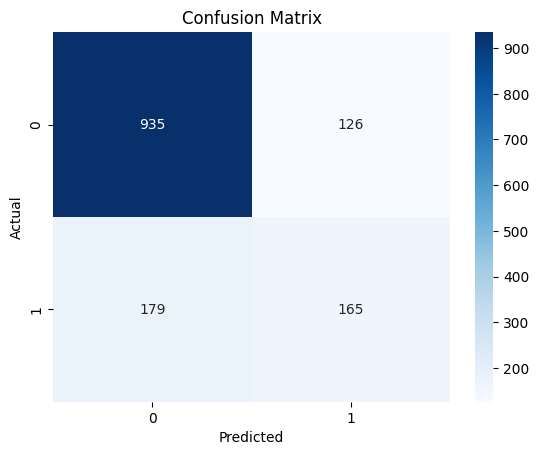

In [136]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()